adapted from https://github.com/vboussange/lineax/blob/main/docs/examples/preconditioner.ipynb

In [1]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '5'


In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
from scipy.sparse import diags, kron, eye
import jax.experimental.sparse as js
import lineax as lx


def poisson(n, m):
    """
    Create a 2D Laplacian matrix on an n-by-m grid as a JAX BCOO sparse matrix.
    """
    lap_1d_n = diags([-1, 2, -1], [-1, 0, 1], shape=(n, n), format="csr")
    lap_1d_m = diags([-1, 2, -1], [-1, 0, 1], shape=(m, m), format="csr")
    lap_2d = kron(eye(m, format="csr"), lap_1d_n) + kron(lap_1d_m, eye(n, format="csr"))
    return js.BCOO.from_scipy_sparse(lap_2d)


In [3]:


# Set up the problem: A x = b
n, m = 25, 25
rho_n = 1000

In [4]:
#gaussian blob...

density = jnp.zeros((n,m))
density = density.at[int(n/2),int(m/2)].set(rho_n)

In [5]:

A = poisson(n, m)
key = jr.PRNGKey(0)
b = density.flatten()

in_structure = jax.eval_shape(lambda: b)

In [6]:

# Define operator and solve with GMRES
class SparseMatrixLinearOperator(lx.MatrixLinearOperator):
    def mv(self, vector):
        return self.matrix @ vector
    

@lx.is_positive_semidefinite.register(SparseMatrixLinearOperator)
def _(op):
    return True
    
operator = SparseMatrixLinearOperator(A)
solver = lx.GMRES(atol=1e-5, rtol=1e-5, max_steps=30)
x = lx.linear_solve(operator, b, solver=solver, throw=False).value

In [7]:
# Check the residual norm
error = jnp.linalg.norm(b - (A @ x))
error

Array(0.00043769, dtype=float32)

In [11]:
@jax.jit
def get_diagonal(matrix):
    """
    Extract the diagonal from a sparse matrix.
    """
    is_diag = matrix.indices[:, 0] == matrix.indices[:, 1]
    diag_values = jnp.where(is_diag, matrix.data, 0)
    diag = jnp.zeros(matrix.shape[0], dtype=matrix.data.dtype)
    diag = diag.at[matrix.indices[:, 0]].add(diag_values)
    return diag

operator = SparseMatrixLinearOperator(A)
solver = lx.GMRES(atol=1e-5, rtol=1e-5, max_steps=30)
x = lx.linear_solve(operator, b, solver=solver, throw=False).value

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


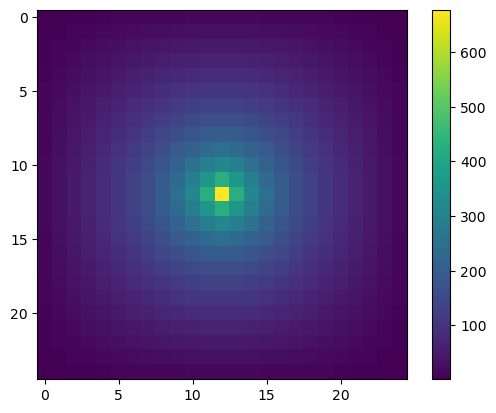

In [12]:
%pylab inline
imshow(x.reshape(m,n))
colorbar()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


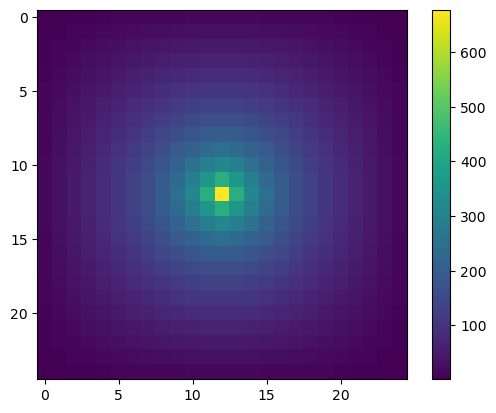

In [13]:
%pylab inline
imshow(x2.reshape(m,n))
colorbar()

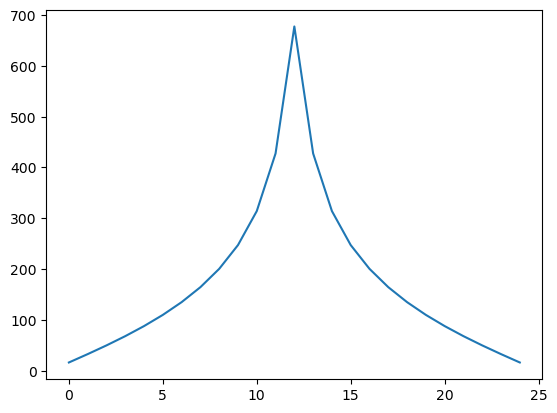

In [14]:
plt.plot(x2.reshape(m,n)[int(m/2)])

In [15]:
#lets see if derivates work...

In [16]:
def likelihood(b):
    x2 = lx.linear_solve(operator, 
                    b, 
                    solver=solver, 
                    options={"preconditioner": preconditioner}, 
                    throw=False).value
    return jnp.sum(x2**2)

In [17]:
likelihood(b)

Array(7913931., dtype=float32)

In [18]:
test_grad = jax.grad(likelihood)

In [19]:
test_grad(b)

TypeError: matmul requires ndarray or scalar arguments, got <class 'jax.experimental.sparse.bcoo.BCOO'> at position 0.

In [20]:
test_grad_fwd = jax.jacfwd(likelihood)

In [21]:
gradfwd = test_grad_fwd(b)

In [22]:
gradfwd #seems to work, but very memory intensive...

Array([  173.54309,   345.60864,   514.3139 ,   677.9112 ,   834.40173,
         981.569  ,  1116.9767 ,  1238.0157 ,  1341.9868 ,  1426.2505 ,
        1488.4163 ,  1526.5574 ,  1539.4175 ,  1526.5566 ,  1488.4165 ,
        1426.251  ,  1341.9861 ,  1238.0149 ,  1116.9767 ,   981.5687 ,
         834.4017 ,   677.9112 ,   514.31366,   345.6085 ,   173.54295,
         345.60846,   688.0666 ,  1024.0793 ,  1350.1644 ,  1662.2047 ,
        1955.8838 ,  2226.3433 ,  2468.353  ,  2676.4219 ,  2845.2803 ,
        2969.9727 ,  3046.5327 ,  3072.3538 ,  3046.5315 ,  2969.9722 ,
        2845.2788 ,  2676.4204 ,  2468.3542 ,  2226.3447 ,  1955.8823 ,
        1662.2048 ,  1350.1637 ,  1024.0786 ,   688.0667 ,   345.60858,
         514.3135 ,  1024.0791 ,  1524.614  ,  2010.5391 ,  2476.1528 ,
        2914.9556 ,  3319.7163 ,  3682.5518 ,  3995.135  ,  4249.2554 ,
        4437.226  ,  4552.783  ,  4591.788  ,  4552.784  ,  4437.2246 ,
        4249.253  ,  3995.1372 ,  3682.5527 ,  3319.7163 ,  2914

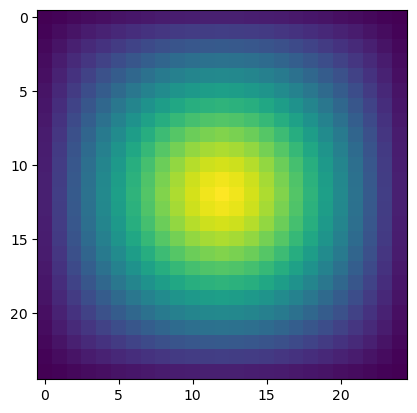

In [23]:
imshow(gradfwd.reshape(m,n))